#### INPUT: GloVe_skipgram.csv, stories.csv
#### OUTPUT: n-clusters

#### Getting processed data

In [1]:
import sklearn as sk
import pandas as pd

df_stories = pd.read_csv('stories.csv', '\n')
df_stories.head()

processedData = list(df_stories["col"]) 

print(processedData)

['wasnt gas passed smell comparison rotten eggs reason memorable source smell coming mouth small room full people assumed someone released gas embarrassed fess real source needless say called mom come get left quickly could sure figured source gone longer smelled like', 'foul litter box whenever walked brothers apartment smell hit immediately entire living room filled smell urine feces lesser extent whole apartment smell emanated gigantic red litter pan sitting right beside entranceway unfortunately brothers roommate four adorable cats could never keep litter pan clean smell deadened senses made feel bit dizzy urine strong smelled like noxious mix chemicals smiled tried gag cats cute stink certainly didnt mention later knew fault helped drag belongings tried breathe mouth inhale eventually left room order keep retching still like cats vow never let cats litter pan stink terribly', 'cant smell tonight coworker fart office left left came window made sniffing gesture ask smelled yet acted

###Getting embeddings for each story

In [4]:
# df_vectors = pd.read_csv('Vectors2.csv', '\t')
# df_vectors.head()

df_vectors = pd.read_csv('GloVe_skipgram_augmented_data_with_backtrans.csv', ',') # change this file name §§§§
#df_vectors = df_vectors.drop(['Unnamed: 0'], axis=1)

df_vectors.head()
# print(df_vectors.shape)GloVe_skipgram


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,-0.064914,0.205180,0.392754,-0.352824,-0.154609,0.163684,-0.089728,0.111764,0.271479,-0.075025,0.080660,0.122661,0.206040,0.146153,0.102451,-0.183797,-0.037181,0.147166,-0.186024,0.222672,0.170491,0.150329,-0.107572,-0.268823,0.001956,0.096358,-0.196415,-0.194200,0.110528,-0.080801,0.106030,0.341475,-0.022802,0.022767,0.089777,0.170607,-0.042175,0.093130,0.194701,...,-0.032518,0.675786,-0.291033,0.046968,0.610971,0.033355,0.436918,-0.172951,-0.029209,-0.228068,0.075855,-0.145741,0.172966,-0.206562,0.071803,0.174630,-0.058394,-0.298165,-0.603718,0.094523,0.380001,-0.019134,-0.505951,0.034845,-1.083794,-0.281438,0.194524,-0.074454,-0.305115,-0.147059,0.112404,-0.140432,-0.189063,-0.111401,-0.459380,-0.024034,-0.209403,-0.129189,0.256008,0.120032
1,1,0.001095,0.194669,0.301159,-0.392945,-0.184984,0.398989,-0.114317,0.095351,0.138070,-0.036207,0.112924,0.119516,0.199941,0.137952,0.063055,-0.030823,-0.045840,0.209437,-0.114558,0.041842,0.111388,0.146193,0.031656,-0.285325,0.162437,0.113141,-0.308160,-0.251864,0.061781,-0.093606,0.080184,0.212766,0.112460,0.104521,0.007453,0.150999,0.050329,0.090708,0.222099,...,0.020368,0.817995,-0.203544,0.182961,0.445867,0.069360,0.435698,-0.138328,-0.078577,-0.276631,0.019950,-0.143212,0.178068,-0.161169,0.034193,0.234482,-0.159507,-0.202894,-0.251318,0.164184,0.253281,0.037684,-0.375586,0.122238,-0.868380,-0.316521,0.193340,-0.010137,-0.282647,0.024566,0.049188,-0.222996,0.005387,-0.010977,-0.305426,-0.056740,-0.195541,-0.068428,0.225303,0.040734
2,2,-0.046463,0.076587,0.291405,-0.291555,-0.202527,0.267016,0.007917,0.169377,0.112903,-0.034587,0.084556,-0.034889,0.137403,0.140157,0.057716,-0.189309,-0.098299,0.212819,-0.174646,0.028439,0.191343,0.245642,-0.116836,-0.342934,0.128819,0.101892,-0.265438,-0.199998,0.188219,-0.193198,-0.030561,0.321832,0.071679,0.056381,0.013798,0.233817,-0.058785,0.022011,0.277767,...,0.023276,0.703713,-0.310856,0.152243,0.322999,-0.001159,0.549023,-0.188920,-0.105462,-0.180748,0.116940,-0.211371,0.185096,-0.229640,0.079999,0.198146,-0.065086,-0.167113,-0.328224,0.033908,0.264851,-0.014914,-0.376657,0.118061,-0.896991,-0.289113,0.196036,0.011361,-0.370478,-0.191431,0.116326,-0.173674,-0.101808,0.046240,-0.284558,0.027690,-0.048838,-0.014473,0.116284,0.238271
3,3,0.141530,0.252226,0.345101,-0.239604,-0.202001,0.261980,-0.229609,0.084784,-0.103161,-0.122158,0.022343,0.062414,0.141887,0.083813,0.072680,-0.209552,-0.099251,0.188894,-0.247649,0.230459,0.139755,0.192997,-0.123675,-0.225316,0.121974,0.137940,-0.430690,-0.361190,0.262817,-0.094190,-0.176541,0.336113,0.030287,0.055895,0.025055,0.078668,-0.241987,0.080854,0.199578,...,0.148289,0.802400,-0.418473,0.022757,0.365407,0.023793,0.626005,0.026434,0.000051,0.021069,-0.058546,-0.186992,0.046651,-0.252666,0.001283,0.283743,-0.240156,-0.220301,-0.407914,-0.050670,0.326732,-0.017169,-0.479831,-0.081422,-1.277611,-0.266737,0.004921,-0.067237,-0.300960,-0.165523,0.045540,-0.123370,0.090814,-0.033305,-0.307785,0.015956,-0.090896,-0.065074,0.307950,0.183472
4,4,-0.015380,0.187494,0.373294,-0.281614,-0.159609,0.356663,-0.023224,0.079436,0.055497,-0.087134,0.036723,0.086194,0.231805,0.073849,0.217705,0.019940,-0.152217,0.054439,-0.121804,0.028782,0.210117,0.199670,0.021212,-0.035061,0.196673,0.134173,-0.270082,-0.101490,0.273147,-0.097841,0.133422,0.140017,-0.074470,0.155021,-0.118736,0.048929,-0.191666,0.035650,0.179140,...,0.063092,0.783650,-0.194055,0.188922,0.194328,-0.038079,0.562015,-0.280691,-0.045917,-0.253125,-0.079455,-0.086145,0.212041,-0.024079,0.063879,0.205430,-0.175832,-0.135840,-0.421379,0.200990,0.386658,0.120924,-0.428091,0.155216,-0.899524,-0.437624,0.071315,-0.009189,-0.333696,-0.101834,0.138488,-0.073348,-0.073707,0.236604,-0.269049,-0.006162,-0.108963,-0.148939,0

In [5]:
#for visualization
import pandas as pd
wiki_lst=[]
title=[]
for story_index, data in enumerate(processedData):
    wiki_lst.append(data)
    title.append(story_index)
print("examine content")
wiki_lst

examine content


['wasnt gas passed smell comparison rotten eggs reason memorable source smell coming mouth small room full people assumed someone released gas embarrassed fess real source needless say called mom come get left quickly could sure figured source gone longer smelled like',
 'foul litter box whenever walked brothers apartment smell hit immediately entire living room filled smell urine feces lesser extent whole apartment smell emanated gigantic red litter pan sitting right beside entranceway unfortunately brothers roommate four adorable cats could never keep litter pan clean smell deadened senses made feel bit dizzy urine strong smelled like noxious mix chemicals smiled tried gag cats cute stink certainly didnt mention later knew fault helped drag belongings tried breathe mouth inhale eventually left room order keep retching still like cats vow never let cats litter pan stink terribly',
 'cant smell tonight coworker fart office left left came window made sniffing gesture ask smelled yet act

#### Trying out PCA / Dim reduction

tutorial used: https://365datascience.com/tutorials/python-tutorials/pca-k-means/ 

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=1fdd6515c33853d6b9a87880c18602a0258943e6f0481d082b08ce799909b467
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
49


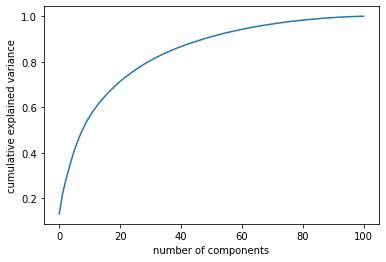

In [6]:
!pip install PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# standardise the data
scaler = StandardScaler()
df_vectors_std = scaler.fit_transform(df_vectors)

# get optimal number of components 
pca = PCA()
pca.fit(df_vectors_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance'); # 45

noComponents = 0 # 0.9 is our baseline
for element in np.cumsum(pca.explained_variance_ratio_):
  noComponents = noComponents + 1
  if element >= 0.9:
    break
print(noComponents)

In [7]:

pca = PCA(n_components=noComponents)

pca.fit(df_vectors_std)

pca.transform(df_vectors_std)

scores_pca = pca.transform(df_vectors_std)


###K-means

tutorial followed:https://realpython.com/k-means-clustering-python/ 

#### Importing the needed modules

In [8]:
!pip install kneed

import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


#### Using the elbow method to find optimal number of clusters

##### Get SSE for different no of clusters

How it works: first plot the SSE for different number of clusters

SSE is defined as the sum of the squared distance between centroid and each member of the cluster

In [9]:
maxNoClusters = 13

kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

# A list holds the SSE values for each k
sse = []

for k in range(1, maxNoClusters):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scores_pca)
  sse.append(kmeans.inertia_)

##### Plot the clusters vs SSE

When you plot SSE as a function of the number of clusters, notice that SSE continues to decrease as you increase k. As more centroids are added, the distance from each point to its closest centroid will decrease.

There’s a sweet spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. In this example, the elbow is located at x=3:



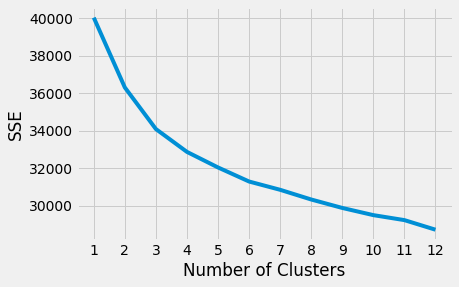

In [10]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, maxNoClusters), sse)
plt.xticks(range(1, maxNoClusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

##### Use this information to get the optimal no clusters

Determining the elbow point in the SSE curve isn’t always straightforward. If you’re having trouble choosing the elbow point of the curve, then you could use a Python package, kneed, to identify the elbow point programmatically:



In [11]:
kl = KneeLocator(range(1, maxNoClusters), sse, curve="convex", direction="decreasing")
print(kl.elbow)
noOfClusters = kl.elbow

4


#### Using Silhouette Coefficient to find optimal number of clusters

##### Get silhouette_score for different no of clusters

In [12]:
silhouette_coefficients = []

for k in range(2, maxNoClusters):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit_predict(scores_pca)
  score = silhouette_score(scores_pca, kmeans.labels_)
  silhouette_coefficients.append(score)

print(silhouette_coefficients[noOfClusters])

0.06015863945022009


##### Plot the clusters vs silhouette_score

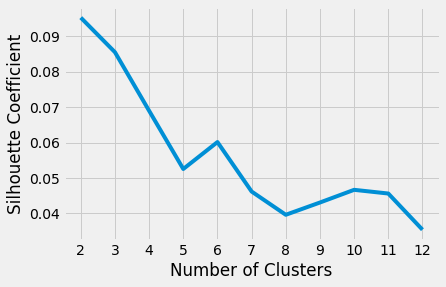

In [13]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, maxNoClusters), silhouette_coefficients)
plt.xticks(range(2, maxNoClusters))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### Using the no of cluster u have decided to do clustering

##### Running K-means

In [14]:
kmeans = KMeans(
       init="random",
       n_clusters=noOfClusters,
       n_init=10,
       max_iter=300,
       random_state=42
      )

kmeans.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=4,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [15]:
# The lowest SSE value
print(kmeans.inertia_)

# Final locations of the centroid
print(kmeans.cluster_centers_)

# The number of iterations required to converge
print(kmeans.n_iter_)


32870.439037276534
[[-3.38759615e+00 -4.80756258e-01  5.79764330e-01 -6.66159537e-01
   4.30302580e-01  2.51354073e-01 -2.93807584e-01  2.27888525e-01
   1.22729106e-01 -4.83415312e-02  5.18655958e-02 -2.55568040e-01
   1.88517961e-01 -4.21941073e-02 -8.44753505e-02 -4.19519020e-02
   2.64340725e-02 -9.67267569e-02  1.07295345e-02  2.73132878e-02
  -2.37284002e-02 -3.54332409e-02  8.48926418e-03  1.32706201e-02
  -1.97020604e-02 -1.65413406e-02  1.79976962e-03  5.16096813e-02
  -5.15460642e-02 -7.18650783e-02 -5.98701141e-02  6.82350875e-02
  -1.17395733e-02  3.49362156e-02  2.59000851e-02  3.08688340e-02
   5.28830815e-02 -1.69166203e-02  5.30561333e-02 -1.09269968e-03
   5.10488888e-03  2.84479374e-02 -1.28507273e-02 -6.01905951e-03
   1.90334931e-02  6.96320754e-03  2.05629823e-02 -1.63081853e-02
   2.89829778e-02]
 [ 1.40160047e+00  3.80882500e+00  2.70112218e-02 -1.08240098e-02
  -2.87230298e-01  3.67673922e-01 -3.00119029e-01 -1.43533754e-01
  -5.13835333e-02 -1.29259756e-01 -5.4

In [16]:
# getting labels for existing points 

print(kmeans.labels_)
print(len(kmeans.labels_))

[0 1 0 0 1 0 0 0 0 1 1 1 0 0 2 1 3 0 2 2 1 0 2 3 0 3 3 2 0 3 0 0 0 2 1 1 2
 0 1 2 1 0 3 0 0 2 3 1 3 3 1 3 3 2 1 1 0 1 0 3 0 0 1 1 0 1 0 2 0 0 1 0 0 1
 1 0 0 3 0 0 3 0 0 0 0 0 0 0 0 3 3 2 0 1 0 0 0 3 1 3 2 0 3 3 3 0 0 1 3 3 3
 3 3 3 0 3 3 0 0 0 3 0 0 2 1 3 3 2 0 0 0 3 2 0 2 3 2 2 2 0 3 0 2 3 2 3 0 3
 0 2 3 1 3 0 2 1 1 0 0 2 3 2 2 2 2 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 2 2 0 0
 0 1 2 2 3 1 2 0 1 1 0 1 0 0 0 0 0 1 0 2 2 0 2 1 2 2 2 2 3 0 0 2 0 0 3 0 0
 1 1 0 0 2 1 3 3 0 0 0 0 0 1 1 3 3 3 0 0 0 1 1 1 1 1 0 1 0 0 0 3 2 3 1 1 1
 0 1 1 1 1 1 0 1 0 1 0 1 1 3 1 1 1 3 2 0 0 3 1 0 0 1 3 1 0 1 3 3 3 1 2 2 3
 3 3 3 3 3 1 3 1 3 3 0 1 3 3 2 2 3 2 2 1 1 0 3 3 3 3 2 2 2 3 2 2 0 2 2 2 1
 2 1 3 3 3 3 2 2 2 2 2 1 1 3 1 1 1 0 3 1 1 0 3 3 1 1 3 2 3 1 3 3 0 0 0 0 1
 1 2 2 2 0 3 3 3 3 0 3 2 0 0 1 3 0 0 0 0 3 0 1 1 3 0 3 3 2 3 2 3 0 0 0 1 2
 2 2 2 2 2 2 3 2 2 2 0 2 2 1 2 2 0 0 1 0 0 2 2 0 3 2 0 0 0 0 1 2]
439


##### Visualising result

Cluster: 0
Titles


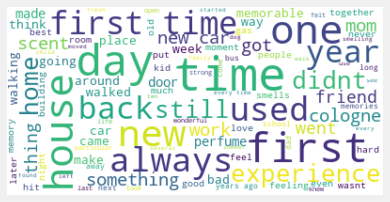

Cluster: 1
Titles


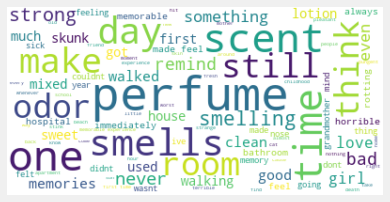

Cluster: 2
Titles


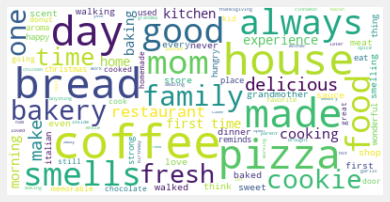

In [17]:
wiki_cl=pd.DataFrame(list(zip(title,kmeans.labels_)),columns=['title','cluster'])
from wordcloud import WordCloud
result={'cluster':kmeans.labels_,'wiki':wiki_lst}
result=pd.DataFrame(result)
for k in range(0,3):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split() if word != "smell" and word != "smelled" and word != "really" and word != "remember"])

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=wiki_cl[wiki_cl.cluster==k]['title']
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    text = "skipgram_k_means" + str(k) + ".png"
    plt.savefig(text)
    plt.show()

In [ ]:
import numpy as np
u_labels = np.unique(kmeans.labels_)
labels = kmeans.labels_
print(u_labels)

groupsOfStories = []

for element in u_labels:
  groupsOfStories.append([])

for i in range(0, len(processedData)):
  groupsOfStories[labels[i]].append(processedData[i])


for label in u_labels:
  print(groupsOfStories[label])

df_result1 = pd.DataFrame(groupsOfStories)

df_result1.to_csv('GloveSkipGram_kmeans.csv', index=False)



[0 1 2]
['wasnt gas passed smell comparison rotten eggs reason memorable source smell coming mouth small room full people assumed someone released gas embarrassed fess real source needless say called mom come get left quickly could sure figured source gone longer smelled like', 'cant smell tonight coworker fart office left left came window made sniffing gesture ask smelled yet acted like didnt keep satisfaction inside actually becoming quiet nauseated played cool gone quickly ran bottle air freshener sprayed whole room smell gas worse thing smelled long time really make puke', 'accidental compliments washed clothes tide sport strong scent didnt know much use clothes used much smelled really strongly smell liked smell alot smelled good everyone else strong walked campus alot people would give compliments good smelled memorable make stupid mistakes like time nice negative consequences', 'thousand dollar smell years ago shopping car spouse found one really liked local dealer think tried d

In [ ]:
import pandas as pd
wiki_lst=[]
title=[]
for story_index, data in enumerate(processedData):
    wiki_lst.append(data)
    title.append(story_index)
print("examine content")
#wiki_lst

examine content


In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=noOfClusters ,affinity='euclidean', linkage='ward')  
labels = cluster.fit_predict(scores_pca)
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
labels
print(len(labels))

439


Cluster: 0
Titles


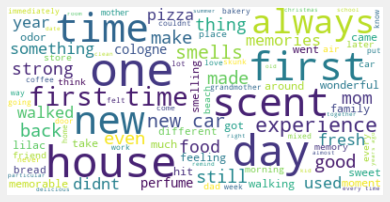

Cluster: 1
Titles


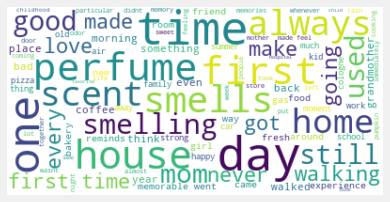

Cluster: 2
Titles


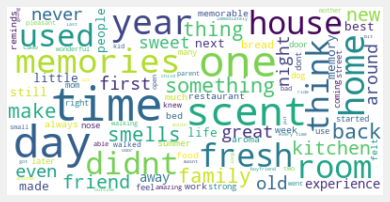

In [ ]:
from wordcloud import WordCloud
result={'cluster':labels,'wiki':wiki_lst}
result=pd.DataFrame(result)

for k in range(0,noOfClusters):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split() if word != "smell" and word != "smelled" and word != "really" and word != "remember"])

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=wiki_cl[wiki_cl.cluster==k]['title']
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    name = "CBOW_PCA_KMEANS" + str(k) + ".png"
    plt.savefig(name)
    plt.show()

#### Evaluation

##### Silhouette Coefficient

[2 1 2 0 0 1 0 0 0 2 0 0 0 2 0 2 2 1 0 0 0 1 1 0 2 2 1 0 0 2 2 1 1 2 2 0 2
 2 0 0 0 0 2 0 0 0 0 0 2 0 0 0 2 2 0 0 2 0 2 2 2 0 2 0 0 0 0 0 0 1 0 0 0 0
 2 0 2 2 2 2 2 2 0 2 2 2 0 0 0 0 2 0 0 2 2 1 1 2 0 2 2 2 2 0 1 0 0 0 0 0 1
 2 1 0 2 2 0 2 2 2 2 2 2 0 2 2 2 0 2 0 2 2 0 2 2 1 1 0 0 0 2 0 0 1 2 1 0 0
 2 0 0 1 0 2 0 0 2 0 2 0 1 0 2 2 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 2 0 1 1
 0 2 0 2 1 0 1 0 0 2 2 0 0 0 0 0 2 0 2 2 0 0 2 0 1 0 0 0 0 0 2 2 2 1 0 2 0
 0 2 2 2 2 1 0 2 0 0 1 0 2 2 0 2 2 0 0 1 0 0 2 0 0 2 2 0 0 0 2 1 0 2 0 2 2
 2 1 0 2 0 0 2 2 2 2 1 0 0 0 2 0 2 1 0 2 2 0 2 0 2 0 1 0 0 0 0 0 0 0 0 2 0
 2 2 0 0 0 0 0 2 0 0 0 0 0 2 0 2 2 0 0 0 2 2 0 0 0 1 2 0 0 0 0 0 2 0 0 2 0
 2 0 2 2 0 2 1 0 0 0 2 2 0 2 0 0 0 1 0 0 0 0 0 2 0 2 2 0 1 0 2 2 0 1 2 2 0
 2 0 2 0 0 0 0 0 0 2 2 1 2 2 0 0 0 0 1 0 2 0 0 2 0 2 0 2 2 1 0 0 2 2 2 2 2
 0 2 0 2 1 0 2 0 0 0 2 0 0 0 0 0 0 0 2 2 2 2 1 0 2 1 2 0 0 0 0 2]
0.12028549603610342


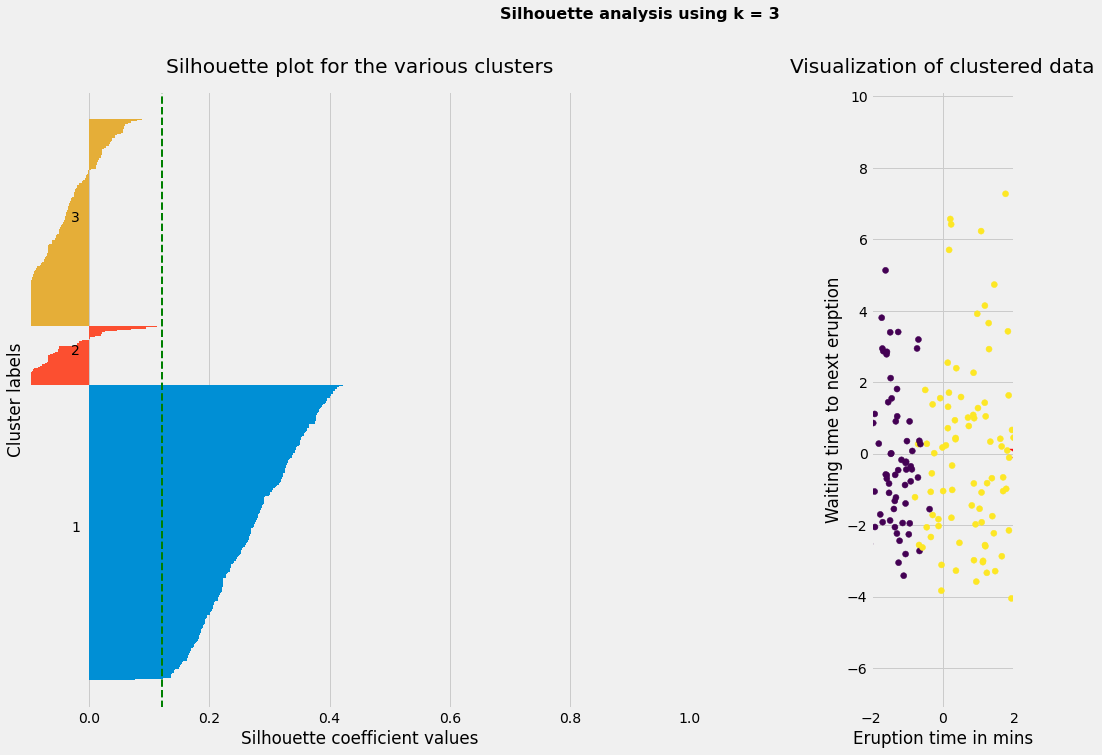

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_coefficients = []

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 10)

km = KMeans(n_clusters=noOfClusters)
labels = km.fit_predict(scores_pca)
centroids = km.cluster_centers_
print(labels)

# Get silhouette samples
silhouette_vals = silhouette_samples(scores_pca, labels)

# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels)):
  cluster_silhouette_vals = silhouette_vals[labels == cluster]
  cluster_silhouette_vals.sort()
  y_upper += len(cluster_silhouette_vals)
  ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
  ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
  y_lower += len(cluster_silhouette_vals)

# Get the average silhouette score and plot it
avg_score = np.mean(silhouette_vals)
ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
ax1.set_yticks([])
ax1.set_xlim([-0.1, 1])
ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster labels')
ax1.set_title('Silhouette plot for the various clusters', y=1.02);
print(avg_score)     
# Scatter plot of data colored with labels
ax2.scatter(scores_pca[:, 0], scores_pca[:, 1], c=labels)
ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
ax2.set_xlim([-2, 2])
ax2.set_xlim([-2, 2])
ax2.set_xlabel('Eruption time in mins')
ax2.set_ylabel('Waiting time to next eruption')
ax2.set_title('Visualization of clustered data', y=1.02)
ax2.set_aspect('equal')
plt.tight_layout()
plt.suptitle(f'Silhouette analysis using k = {noOfClusters}',
                  fontsize=16, fontweight='semibold', y=1.05);

##### Calinski-Harabasz Index

In [ ]:
from sklearn.metrics import calinski_harabasz_score

km = KMeans(n_clusters=noOfClusters)
labels = km.fit_predict(scores_pca)

calinski_harabasz_val = calinski_harabasz_score(scores_pca, labels)
print(calinski_harabasz_val)

52.417556008917906


##### Davies-Bouldin Index

In [ ]:
from sklearn.metrics import davies_bouldin_score

km = KMeans(n_clusters=noOfClusters)
labels = km.fit_predict(scores_pca)

davies_bouldin_val = davies_bouldin_score(scores_pca, labels)
print(davies_bouldin_val)

2.871069080310774
